**Date**: 2019-03-04

**Authors**: Adam Stafford

**Purpose**: To test whether the 4 new TFBS increase accuracy.

This notebook is like the one from 2019-01-29, except it adds the new data. 

**Background**:

With 4 TFBS we were getting over 80% accuracy. We wold like to see if we can get higher with 8 TFBS

**Experiment**:

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Load the `pickle` buffered list:

In [ ]:
with open("../../data/larger_dataset/larger_dataset_buffer.txt", "rb") as buff:
    seq_record_list = pickle.load(buff)

The following cell retains only 4800 sequences, for the purpose of testing speed. It also randomly shuffles the 4800 sequences.

In [3]:
seq_record_list = seq_record_list[:4800]
from random import shuffle
shuffle(seq_record_list)

The following cell transforms the data into a format that is recognizable by the neural network model.

In [4]:
# A helper function to flatten a 2d list to 1d.
# Input: [[1, 2], [2, 3], [3, 4, 5]]
# Output: [1, 2, 2, 3, 3, 4, 5]
def flatten(lst):
    new_lst = []
    for sub_lst in lst:
        for item in sub_lst:
            new_lst.append(item)
    return new_lst

# A helper function to transform a lst so that its length becomes read_len by:
# 1. If len(lst) > read_len, curtail the end of the lst.
# 2. If len(lst) < read_len, keep extending the end of the lst with 0 (NA).
def curtail(lst, read_len):
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    return lst

# Produce the train-test split
# length_read: the length that you want all DNA sequences to conform to
def prepare_input(training_size, test_size, length_read):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    seq_count = 0
    while seq_count < training_size:
        X_train.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_train.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    while seq_count < (training_size + test_size):
        X_test.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_test.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    return X_train, y_train, X_test, y_test

# Turn list into numpy tensors that can directly feed into a neural network model
def to_np_array(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if len(y_train.shape) == 1:
        y_train = np.transpose(np.array([y_train]))
    X_test = np.array(X_test)
    y_test = np.transpose(np.array(y_test))
    if len(y_test.shape) == 1:
        y_test = np.transpose(np.array([y_test]))
    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = prepare_input(4320, 480, 1000)
X_train, y_train, X_test, y_test = to_np_array(X_train, y_train, X_test, y_test)
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]

[(4320, 12000), (4320, 1), (480, 12000), (480, 1)]

The following cells build a recurrent network with one bidirectional LSTM layer.

In [6]:
from keras.models import Model, Sequential
from keras.layers import Dense, CuDNNLSTM, Bidirectional

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
X_train_rnn = X_train.reshape(4320, 1000, 12)

In [18]:
model = Sequential()
#model.add(CuDNNLSTM(8, input_shape=(1000, 8), return_sequences=True))
model.add(Bidirectional(CuDNNLSTM(16), input_shape=(1000, 12)))
#model.add(CuDNNLSTM(8, return_sequences=True))
#model.add(CuDNNLSTM(4, return_sequences=True))
#model.add(CuDNNLSTM(4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_rnn, y_train, epochs=150, batch_size=128, validation_split=0.1)

Train on 3888 samples, validate on 432 samples
Epoch 1/150
3888/3888 [==============================] - 6s 2ms/step - loss: 0.6854 - acc: 0.5599 - val_loss: 0.6826 - val_acc: 0.5486
Epoch 2/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6631 - acc: 0.6067 - val_loss: 0.6708 - val_acc: 0.5949
Epoch 3/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6516 - acc: 0.6337 - val_loss: 0.6655 - val_acc: 0.5856
Epoch 4/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6414 - acc: 0.6463 - val_loss: 0.6560 - val_acc: 0.6088
Epoch 5/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6318 - acc: 0.6633 - val_loss: 0.6455 - val_acc: 0.6343
Epoch 6/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6216 - acc: 0.6754 - val_loss: 0.6401 - val_acc: 0.6227
Epoch 7/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6115 - acc: 0.6896 - val_loss: 0.6273 - val_acc: 0.6690
Epoch 8/

Epoch 61/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.2546 - acc: 0.8971 - val_loss: 0.3034 - val_acc: 0.8866
Epoch 62/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.2491 - acc: 0.9051 - val_loss: 0.3028 - val_acc: 0.8819
Epoch 63/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.2488 - acc: 0.9030 - val_loss: 0.2861 - val_acc: 0.8981
Epoch 64/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.2451 - acc: 0.9035 - val_loss: 0.2865 - val_acc: 0.8866
Epoch 65/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.2362 - acc: 0.9102 - val_loss: 0.3854 - val_acc: 0.8426
Epoch 66/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.2454 - acc: 0.9017 - val_loss: 0.3148 - val_acc: 0.8657
Epoch 67/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.2352 - acc: 0.9100 - val_loss: 0.2911 - val_acc: 0.8866
Epoch 68/150
3888/3888 [========================

3888/3888 [==============================] - 5s 1ms/step - loss: 0.1277 - acc: 0.9542 - val_loss: 0.2425 - val_acc: 0.9144
Epoch 122/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.1298 - acc: 0.9529 - val_loss: 0.2940 - val_acc: 0.8889
Epoch 123/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.1208 - acc: 0.9586 - val_loss: 0.2613 - val_acc: 0.8935
Epoch 124/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.1195 - acc: 0.9594 - val_loss: 0.2375 - val_acc: 0.9051
Epoch 125/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.1176 - acc: 0.9588 - val_loss: 0.3495 - val_acc: 0.8657
Epoch 126/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.1192 - acc: 0.9624 - val_loss: 0.2384 - val_acc: 0.9144
Epoch 127/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.1136 - acc: 0.9635 - val_loss: 0.3004 - val_acc: 0.8866
Epoch 128/150
3888/3888 [==============================

**Result**:

The following cell **visualize** the training/validation accuracies and losses over each epoch.

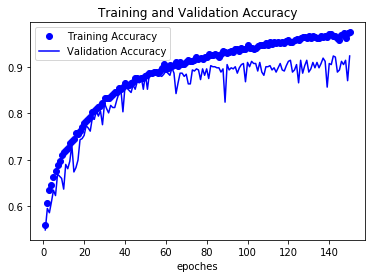

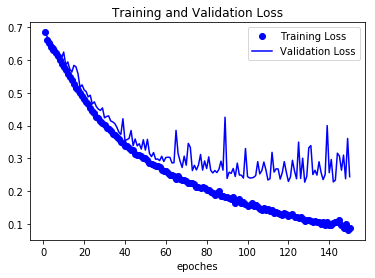

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoches')
plt.legend()

plt.show()

In [21]:
import utility
utility.save_model(model, 'models/adam_2019_04_13.json', 'models/adam_2019_04_13_weights.h5')

Save model to models/adam_2019_04_13.json


- The validation trend now follows closely to the training trend.

**Conclusion**:

- The result of the experiment demonstrates a marked improvement over previous experiments and suggests that using more TFBS increases accuracy.


### False Discovery Rate

In [10]:
import utility
model = utility.load_model('../models/adam_2019_04_13.json', '../models/adam_2019_04_13_weights.h5')

Loaded model from ../models/adam_2019_04_13.json


In [11]:
X_test_rnn = X_test.reshape(480, 1000, 12)
results = model.predict(X_test_rnn, batch_size=16)

false_positives = 0
true_positives = 0
total_negatives = 0
total_positives = 0
true_negatives = 0

for i in range(0,results.size):
    
    if results[i][0]>=0.5 and y_test[i]==0:
        false_positives += 1

    if results[i][0]>=0.5 and y_test[i]==1:
        true_positives += 1
        
    if results[i][0]<=0.5 and y_test[i]==0:
        true_negatives += 1
        
    if results[i][0] <= 0.5:
        total_negatives += 1
        
    if results[i][0] >= 0.5:
        total_positives += 1

false_discovery_rate = false_positives/(false_positives + true_positives)
print("The false discovery rate is: {}".format(false_discovery_rate))

The false discovery rate is: 0.044444444444444446


ROC Curve


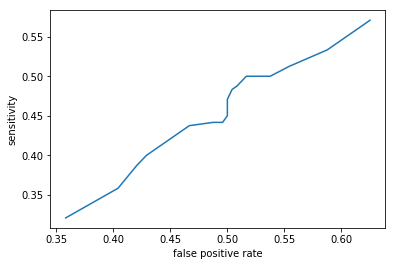

c-statistic = 0.12057291666666668


In [12]:
sensitivities = []
false_positive_rates =[]
discovery_percentage = 0.05

while discovery_percentage < 1.0:
    
    false_positives = 0
    true_positives = 0
    total_negatives = 0
    total_positives = 0
    true_negatives = 0
    
    for i in range(0,results.size):

        if results[i][0]>=discovery_percentage and y_train[i]==0:
            false_positives += 1

        if results[i][0]>=discovery_percentage and y_train[i]==1:
            true_positives += 1

        if results[i][0]<=discovery_percentage and y_train[i]==0:
            true_negatives += 1

        if y_train[i]==0:
            total_negatives += 1

        if y_train[i]==1:
            total_positives += 1
            
    if total_positives != 0 and total_negatives != 0:
        sensitivities.append(true_positives / total_positives)
        false_positive_rates.append(1-(true_negatives / total_negatives))
    
    discovery_percentage += 0.05
    
riemann = 0.0
for i in range(0,len(sensitivities) - 1):
    riemann += 0.5 * (sensitivities[i]+sensitivities[i+1]) * (false_positive_rates[i]-false_positive_rates[i+1])
    

print("ROC Curve")
plt.plot(false_positive_rates, sensitivities )
plt.ylabel('sensitivity')
plt.xlabel('false positive rate')
plt.show()
print("c-statistic = " + str(riemann))
